# Introduction

Name : Rahardiansyah Fatoni

Batch : RMT-027

Live Code 4 - Set 1, Objective : Machine learning on correlation between features to price of medical care.

# Importing Libraries

In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.preprocessing import PolynomialFeatures

# Data Loading

In [533]:
df = pd.read_csv('/content/insurance.csv')

In [534]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Dataset Description:
- `age` : Age of beneficiary
- `sex` : Gender of beneficiary
- `bmi` : Body Mass Index
- `children` : Number of dependents
- `smoker` : Smoker or not smoker
- `region` : Residential of beneficiary in the U.S.
- `charges` : Individual medical costs

In [535]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


$Insight:$
- There are 1338 entries in 7 columns with dtypes : float64(2), int64(2), object(3)
- No detectable NaN values in entries.

In [536]:
df.duplicated().sum()

1

In [537]:
df.drop_duplicates(inplace=True)

# Feature Engineering

In [538]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Split X (Features) and Y (Target)

In [539]:
x = df.drop(columns='charges')

In [540]:
y = df['charges']

In [541]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=44)

In [542]:
x_train.shape,  x_test.shape

((1069, 6), (268, 6))

In [543]:
category_cols = df.select_dtypes(include=object).columns.tolist()
num_cols = df.select_dtypes(include=np.number).columns.tolist()

In [544]:
category_cols

['sex', 'smoker', 'region']

In [545]:
num_cols

['age', 'bmi', 'children', 'charges']

### Checking Cardinality in Categoric Features

In [546]:
for col in category_cols:
  print(f"{col} unique values: {len(df[col].unique())}")

sex unique values: 2
smoker unique values: 2
region unique values: 4


$Insight:$
- All categoric columns have low cardinality (<5)

## Detecting Outlier

In [547]:
for col in num_cols:
  print(f"{col} skew value: {df[col].skew()}")

age skew value: 0.054780773126998195
bmi skew value: 0.28391419385321137
children skew value: 0.9374206440474123
charges skew value: 1.5153909108403483


$Insight:$
- `age` have a normal distribution
- `bmi` and `children` have a right skew (>0.5)

In [548]:
def find_normal_boundaries(df, variable):
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [549]:
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [550]:
# Calculate boundaries for `age`

upper_boundary_age, lower_boundary_age = find_normal_boundaries(x_train, 'age')
upper_boundary_age, lower_boundary_age

(81.87848338239769, -3.2610839436699095)

In [551]:
# Identify outliers in `bmi` in the dataset. Lets look for extreme values using IQR * 1.5

upper_boundary_bmi, lower_boundary_bmi = find_skewed_boundaries(x_train, 'bmi', 1.5)
upper_boundary_bmi, lower_boundary_bmi

(47.38499999999999, 13.825000000000005)

In [552]:
# Identify outliers in `children` in the dataset. Lets look again for extreme values using IQR * 1.5

upper_boundary_children, lower_boundary_children = find_skewed_boundaries(x_train, 'children', 1.5)
upper_boundary_children, lower_boundary_children

(5.0, -3.0)

## Handling Outliers

In [553]:
# Flag the outliers in category `age`
outliers_age = np.where(x_train['age'] > upper_boundary_age, True,
                       np.where(x_train['age'] < lower_boundary_age, True, False))

# Flag the outliers in category `bmi`
outliers_bmi = np.where(x_train['bmi'] > upper_boundary_bmi, True,
                       np.where(x_train['bmi'] < lower_boundary_bmi, True, False))

# Flag the outliers in category `children`
outliers_children = np.where(x_train['children'] > upper_boundary_children, True,
                       np.where(x_train['children'] < lower_boundary_children, True, False))

# Trimming the dataset
x_train_trimmed = x_train.loc[~(outliers_age + outliers_children + outliers_bmi)]

print('Size dataset - Before trimming : ', x_train.shape)
print('Size dataset - After trimming  : ', x_train_trimmed.shape)

Size dataset - Before trimming :  (1069, 6)
Size dataset - After trimming  :  (1063, 6)


We can see that using trimming, we removed 6 rows, from a dataset of 1069 rows. This is less than 1% of the data was removed.

In [554]:
after_trimmed_indice = x_train_trimmed.index

y_train_trimmed = y_train.loc[after_trimmed_indice]

In [555]:
x_train = x_train_trimmed
y_train = y_train_trimmed

## Handling Missing Values

In [556]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We have no missing values.

## Feature Selection

### Selecting Categorical Features

In [557]:
for col in category_cols:
  corr_tau, pval_k = stats.kendalltau(df[col], df['charges'])

  if pval_k > 0.05:
    print("")
    print(f"No significant correlation between {col} and charges")
  else:
    print("")
    print(f"Significant correlation between {col} and charge:")
    print(f" Kendall correlation: {corr_tau:.2f}, p-value: {pval_k}")


No significant correlation between sex and charges

Significant correlation between smoker and charge:
 Kendall correlation: 0.54, p-value: 5.734773588751529e-130

No significant correlation between region and charges


$Insight:$
- Only `smoker` have a significant correlation to the target.

In [558]:
x_train = x_train.drop(columns=['sex','region'])

In [559]:
x_test = x_test.drop(columns=['sex','region'])

### Selecting Numerical Features

In [560]:
for col in num_cols:
  corr_r, pval_p = stats.pearsonr(df['charges'], df[col])

  if pval_p > 0.05:
    print("")
    print(f"No significant correlation between {col} and charges")
  else:
    print("")
    print(f"Significant correlation between {col} and charge:")
    print(f" Pearson correlation: {corr_r:.2f}, p-value: {pval_p}")


Significant correlation between age and charge:
 Pearson correlation: 0.30, p-value: 6.975748762691639e-29

Significant correlation between bmi and charge:
 Pearson correlation: 0.20, p-value: 2.4680404264512877e-13

Significant correlation between children and charge:
 Pearson correlation: 0.07, p-value: 0.013717026292987098

Significant correlation between charges and charge:
 Pearson correlation: 1.00, p-value: 0.0


$Insight:$
- `age`, `bmi`, and `children` all have significant correlation to the target

In [561]:
x_train

,age,bmi,children,smoker
709,36,27.740,0,no
1253,40,29.300,4,no
917,45,22.895,0,yes
723,19,35.400,0,no
643,23,34.960,3,no
...,...,...,...,...
84,37,34.800,2,yes
96,54,30.800,3,no
571,18,37.290,1,no
1198,40,29.355,1,no


In [562]:
x_test

,age,bmi,children,smoker
440,31,32.680,1,no
1203,51,32.300,1,no
821,26,17.670,0,no
731,53,21.400,1,no
78,22,39.805,0,no
...,...,...,...,...
1058,24,39.490,0,no
1227,42,37.180,2,no
944,62,39.930,0,no
19,30,35.300,0,yes


## Split between Numerical Columns and Categorical Columns

In [563]:
category_cols = ['smoker']
num_cols = ['age', 'bmi', 'children']

In [564]:
x_train_kat = x_train[category_cols]
x_test_kat = x_test[category_cols]
x_train_num = x_train[num_cols]
x_test_num = x_test[num_cols]

## Feature Scaling

In [567]:
scaler = StandardScaler()

In [568]:
x_train_num = scaler.fit_transform(x_train[num_cols])
x_test_num = scaler.transform(x_test[num_cols])

In [569]:
x_train_num

array([[-0.2316377 , -0.50166864, -0.91364839],
       [ 0.05033296, -0.23580124,  2.39822966],
       [ 0.40279627, -1.32739143, -0.91364839],
       ...,
       [-1.50050564,  1.12591705, -0.08567888],
       [ 0.05033296, -0.22642771, -0.08567888],
       [-1.07754966,  0.50215122,  2.39822966]])

## Feature Encoding

In [570]:
x_train_kat['smoker'].unique()

array(['no', 'yes'], dtype=object)

In [571]:
enc_nom = OneHotEncoder()

In [572]:
enc_nom.fit(x_train_kat[category_cols])

OneHotEncoder()

In [574]:
x_train_enc = enc_nom.transform(x_train_kat[category_cols]).toarray()
x_test_enc = enc_nom.transform(x_test_kat[category_cols]).toarray()

In [ ]:
x_train_enc

In [ ]:
x_test_enc

# Concate between Numerical Columns and Categorical Columns

In [580]:
dt_kat_nom = x_train_kat[category_cols].copy()
dt_kat_nom_test = x_test_kat[category_cols].copy()

In [581]:
dt_kat_nom[['smoker_no','smoker_yes']]=x_train_enc

In [582]:
dt_kat_nom_test[['smoker_no','smoker_yes']]=x_test_enc

In [584]:
dt_kat_nom.drop(columns='smoker',inplace= True)

In [585]:
dt_kat_nom_test.drop(columns='smoker',inplace= True)

In [586]:
dt_kat_nom = dt_kat_nom.reset_index(drop=True)

In [587]:
dt_kat_nom_test = dt_kat_nom_test.reset_index(drop=True)

#### for `x_train_final`:

In [588]:
x_train_final = pd.DataFrame()

In [589]:
x_train_final[num_cols] = x_train_num
x_train_final = x_train_final.reset_index(drop=True)

In [594]:
x_train_num.shape

(1063, 3)

In [591]:
x_train_final = pd.concat([x_train_final, dt_kat_nom], axis= 1)

In [593]:
x_train_final.shape

(1063, 5)

In [595]:
x_train_final

,age,bmi,children,smoker_no,smoker_yes
0,-0.231638,-0.501669,-0.913648,1.0,0.0
1,0.050333,-0.235801,2.398230,1.0,0.0
2,0.402796,-1.327391,-0.913648,0.0,1.0
3,-1.430013,0.803808,-0.913648,1.0,0.0
4,-1.148042,0.728820,1.570260,1.0,0.0
...,...,...,...,...,...
1058,-0.161145,0.701552,0.742291,0.0,1.0
1059,1.037230,0.019840,1.570260,1.0,0.0
1060,-1.500506,1.125917,-0.085679,1.0,0.0
1061,0.050333,-0.226428,-0.085679,1.0,0.0


#### for `x_test_final`:

In [596]:
x_test_final = pd.DataFrame()

In [597]:
x_test_final[num_cols] = x_test_num
x_test_final = x_test_final.reset_index(drop=True)

In [598]:
x_test_final = pd.concat([x_test_final, dt_kat_nom_test], axis= 1)

In [599]:
x_test_final

,age,bmi,children,smoker_no,smoker_yes
0,-0.584101,0.340245,-0.085679,1.0,0.0
1,0.825752,0.275482,-0.085679,1.0,0.0
2,-0.936564,-2.217877,-0.913648,1.0,0.0
3,0.966738,-1.582181,-0.085679,1.0,0.0
4,-1.218535,1.554543,-0.913648,1.0,0.0
...,...,...,...,...,...
263,-1.077550,1.500858,-0.913648,1.0,0.0
264,0.191318,1.107170,0.742291,1.0,0.0
265,1.601172,1.575846,-0.913648,1.0,0.0
266,-0.654594,0.786766,-0.913648,0.0,1.0


# Model Definition

1. Algoritma yang dipakai adalah `Linear Regression`
   * Alasan : ??

2. Metrics yang akan dipakai adalah `Mean Absolute Error (MAE)`
   * Alasan : ??

In [604]:
model_lin_reg = LinearRegression()
model_lasso_alpha_01 = Lasso(alpha=0.1)
model_ridge_alpha_01 = Ridge(alpha=0.1)

# Model Training

## Linear Regression

In [605]:
model_lin_reg.fit(x_train_final, y_train)

LinearRegression()

In [606]:
y_train_pred_lr = model_lin_reg.predict(x_train_final)
y_test_pred_lr = model_lin_reg.predict(x_test_final)

In [614]:
print("Linear Regression Training Evaluation: ")
print("")
MAE_value = mean_absolute_error(y_train,y_train_pred_lr)
print("Mean Absolute Error: ", MAE_value)

MSE_value = mean_squared_error(y_train,y_train_pred_lr)
print("Mean Squared Absolute Error: ", MSE_value)

RMSE_value = mean_squared_error(y_train,y_train_pred_lr, squared=False)
print("Root Mean Squared Absolute Error: ", RMSE_value)

r2_score_value = r2_score(y_train,y_train_pred_lr)
print("r2 score: ", r2_score_value)

Linear Regression Training Evaluation: 

Mean Absolute Error:  4245.171885869366
Mean Squared Absolute Error:  37682639.73146772
Root Mean Squared Absolute Error:  6138.618715270376
r2 score:  0.7405566484230008


In [613]:
print("Linear Regression Test Evaluation: ")
print("")
MAE_value = mean_absolute_error(y_test,y_test_pred_lr)
print("Mean Absolute Error: ", MAE_value)

MSE_value = mean_squared_error(y_test,y_test_pred_lr)
print("Mean Squared Absolute Error: ", MSE_value)

RMSE_value = mean_squared_error(y_test,y_test_pred_lr, squared=False)
print("Root Mean Squared Absolute Error: ", RMSE_value)

r2_score_value = r2_score(y_test,y_test_pred_lr)
print("r2 score: ", r2_score_value)

Linear Regression Test Evaluation: 

Mean Absolute Error:  3920.9376689323185
Mean Squared Absolute Error:  30603031.157803316
Root Mean Squared Absolute Error:  5532.000646945309
r2 score:  0.781992386057822


## Lasso Regression

In [611]:
model_lasso_alpha_01.fit(x_train_final, y_train)

Lasso(alpha=0.1)

In [612]:
y_train_pred_ls = model_lasso_alpha_01.predict(x_train_final)
y_test_pred_ls = model_lasso_alpha_01.predict(x_test_final)

In [616]:
print("Lasso Regression Training Evaluation: ")
print("")
MAE_value = mean_absolute_error(y_train,y_train_pred_ls)
print("Mean Absolute Error: ", MAE_value)

MSE_value = mean_squared_error(y_train,y_train_pred_ls)
print("Mean Squared Absolute Error: ", MSE_value)

RMSE_value = mean_squared_error(y_train,y_train_pred_ls, squared=False)
print("Root Mean Squared Absolute Error: ", RMSE_value)

r2_score_value = r2_score(y_train,y_train_pred_ls)
print("r2 score: ", r2_score_value)

Lasso Regression Training Evaluation: 

Mean Absolute Error:  4245.194164307071
Mean Squared Absolute Error:  37682639.82241096
Root Mean Squared Absolute Error:  6138.618722677844
r2 score:  0.7405566477968605


In [617]:
print("Lasso Regression Test Evaluation: ")
print("")
MAE_value = mean_absolute_error(y_test,y_test_pred_ls)
print("Mean Absolute Error: ", MAE_value)

MSE_value = mean_squared_error(y_test,y_test_pred_ls)
print("Mean Squared Absolute Error: ", MSE_value)

RMSE_value = mean_squared_error(y_test,y_test_pred_ls, squared=False)
print("Root Mean Squared Absolute Error: ", RMSE_value)

r2_score_value = r2_score(y_test,y_test_pred_ls)
print("r2 score: ", r2_score_value)

Lasso Regression Test Evaluation: 

Mean Absolute Error:  3920.945435854719
Mean Squared Absolute Error:  30602929.22001438
Root Mean Squared Absolute Error:  5531.991433472614
r2 score:  0.7819931122347167


## Ridge Regression

In [618]:
model_ridge_alpha_01.fit(x_train_final, y_train)

Ridge(alpha=0.1)

In [619]:
y_train_pred_r = model_ridge_alpha_01.predict(x_train_final)
y_test_pred_r = model_ridge_alpha_01.predict(x_test_final)

In [620]:
print("Ridge Regression Training Evaluation: ")
print("")
MAE_value = mean_absolute_error(y_train,y_train_pred_r)
print("Mean Absolute Error: ", MAE_value)

MSE_value = mean_squared_error(y_train,y_train_pred_r)
print("Mean Squared Absolute Error: ", MSE_value)

RMSE_value = mean_squared_error(y_train,y_train_pred_r, squared=False)
print("Root Mean Squared Absolute Error: ", RMSE_value)

r2_score_value = r2_score(y_train,y_train_pred_r)
print("r2 score: ", r2_score_value)

Ridge Regression Training Evaluation: 

Mean Absolute Error:  4245.646472015086
Mean Squared Absolute Error:  37682647.6428465
Root Mean Squared Absolute Error:  6138.619359664394
r2 score:  0.7405565939534986


In [621]:
print("Ridge Regression Test Evaluation: ")
print("")
MAE_value = mean_absolute_error(y_test,y_test_pred_r)
print("Mean Absolute Error: ", MAE_value)

MSE_value = mean_squared_error(y_test,y_test_pred_r)
print("Mean Squared Absolute Error: ", MSE_value)

RMSE_value = mean_squared_error(y_test,y_test_pred_r, squared=False)
print("Root Mean Squared Absolute Error: ", RMSE_value)

r2_score_value = r2_score(y_test,y_test_pred_r)
print("r2 score: ", r2_score_value)

Ridge Regression Test Evaluation: 

Mean Absolute Error:  3921.2786929517238
Mean Squared Absolute Error:  30601910.259510063
Root Mean Squared Absolute Error:  5531.899335626966
r2 score:  0.7820003710303276


# Model Evaluation

In [623]:
y_train_pred_r.min()

-1362.8857562699013

In [625]:
y_train_pred_r.max()

41072.51745829954

In [624]:
y_train.min()

1131.5066

In [626]:
y_train.max()

62592.87309

$Insight:$
- The min/max charges from the prediction is significantly lower than the actual min/max charges.

In [631]:
print(y_train_pred_r.mean())
print(y_train.mean())

13372.247380855124
13372.247380855126


In [632]:
print(y_test_pred_r.mean())
print(y_test.mean())

13114.334762380062
12684.854065671641


$Insight:$
- The mean charges from the prediction is similar in the train-set
- The mean charges from the test-set is slightly higher than the actual charges.

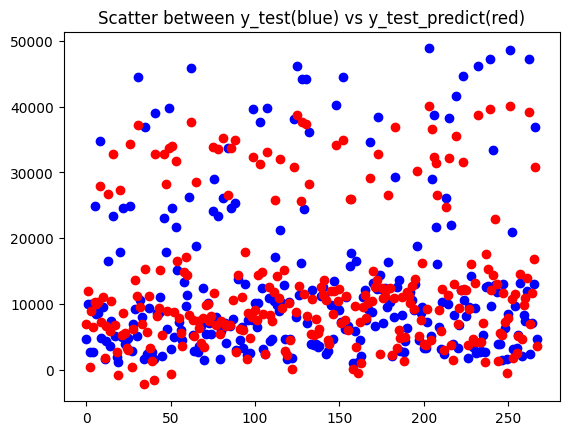

In [636]:
def plotGraph(y_test,y_test_pred_r,regressorName):
    if max(y_test) >= max(y_test_pred_r):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_test_pred_r))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_test_pred_r)), y_test_pred_r, color='red')
    plt.title(regressorName)
    plt.show()
    return

plotGraph(y_test, y_test_pred_r, "Scatter between y_test(blue) vs y_test_predict(red)")

$Insight:$
- The y_test_predict are more compacted into the 30000-4000 range

# Model Saving

In [638]:
import pickle, joblib
import json

with open('model_lin_reg.pkl', 'wb') as file_1:
  pickle.dump(model_lin_reg, file_1)

with open('model_scaler.pkl', 'wb') as file_2:
  pickle.dump(scaler, file_2)

with open('model_encoder.pkl', 'wb') as file_3:
  pickle.dump(enc_nom, file_3)

with open('list_num_cols.txt', 'w') as file_4:
  json.dump(num_cols, file_4)

with open('list_cat_cols.txt','w') as file_5:
  json.dump(category_cols, file_5)

# Conclusion

- The chosen metric is MSE, because the target is a currency and therefore cannot be negative.
- The Model's weakness is that the prediction doesn't go higher than around 40000, despite the actual data being in that range.